In [302]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Function to fetch movie details from OMDb API
def fetch_omdb_details(title):
    omdb_api_key = "28b8fdee"
    omdb_base_url = "http://www.omdbapi.com/"
    url = f"{omdb_base_url}?t={title}&apikey={omdb_api_key}"
    response = requests.get(url)
    return response.json()

# Fetch OMDb details for each movie in TMDb data
omdb_data = []
for title in tmdb_df['title']:
    omdb_details = fetch_omdb_details(title)
    if omdb_details.get("Response") == "True":
        omdb_data.append(omdb_details)

# Create a DataFrame for OMDb data
df = pd.DataFrame(omdb_data)

In [303]:
df.columns

Index(['Title', 'Year', 'Rated', 'Released', 'Runtime', 'Genre', 'Director',
       'Writer', 'Actors', 'Plot', 'Language', 'Country', 'Awards', 'Poster',
       'Ratings', 'Metascore', 'imdbRating', 'imdbVotes', 'imdbID', 'Type',
       'DVD', 'BoxOffice', 'Production', 'Website', 'Response',
       'totalSeasons'],
      dtype='object')

In [304]:
# Selecting relevant columns from the merged DataFrame
df = df[['Title', 'Rated', 'Released', 'Runtime', 'Genre', 'Director','Writer', 'Actors', 'Awards', 'imdbRating']]


In [305]:
df.columns

Index(['Title', 'Rated', 'Released', 'Runtime', 'Genre', 'Director', 'Writer',
       'Actors', 'Awards', 'imdbRating'],
      dtype='object')

In [306]:
# Clean Data
df['Released'] = pd.to_datetime(df['Released'], format='%d %b %Y', errors='coerce')
df['Runtime'] = df['Runtime'].str.replace(' min', '', regex=False)  # Remove ' min'
df['Runtime'] = pd.to_numeric(df['Runtime'], errors='coerce') 

In [307]:
df['Awards'].unique()

array(['N/A', '1 win & 2 nominations', '2 nominations',
       '3 wins & 2 nominations', '1 win & 1 nomination',
       '2 wins & 3 nominations', '29 wins & 78 nominations',
       '3 nominations', '6 wins & 9 nominations', '1 nomination',
       '2 wins & 12 nominations',
       'Won 1 Oscar. 7 wins & 6 nominations total',
       'Nominated for 1 Primetime Emmy. 2 nominations total',
       'Nominated for 2 Oscars. 22 wins & 90 nominations total'],
      dtype=object)

In [308]:
df['imdbRating'] = df['imdbRating'].replace(['N/A', 'NaN', ''], np.nan)
df['imdbRating'] = pd.to_numeric(df['imdbRating'], errors='coerce')
df['imdbRating'] = df['imdbRating'].fillna(df['imdbRating'].mean())
df['Rated'] = df['Rated'].replace(['N/A', 'Not Rated', ''], np.nan)
df['Rated'] = df['Rated'].fillna('Not Rated')
df['Awards'] = df['Awards'].replace('N/A', np.nan)
# Function to extract wins and nominations from the 'Awards' column
def extract_awards(award_str):
    if pd.isna(award_str):
        return np.nan, np.nan  # Return NaN for both if empty
    else:
        # Extract numbers using regex for wins and nominations
        import re
        wins = re.search(r'(\d+)\s+win', award_str)
        nominations = re.search(r'(\d+)\s+nominations?', award_str)
        
        # If wins or nominations are found, return the numbers, else return 0
        win_count = int(wins.group(1)) if wins else 0
        nomination_count = int(nominations.group(1)) if nominations else 0
        
        return win_count, nomination_count

# Apply the function to split the awards into two columns: 'Wins' and 'Nominations'
df[['Wins', 'Nominations']] = df['Awards'].apply(lambda x: pd.Series(extract_awards(x)))
df['Wins'] = df['Wins'].fillna(0)
df['Nominations'] = df['Nominations'].fillna(0)
df['Wins'] = df['Wins'].astype(int)
df['Nominations'] = df['Nominations'].astype(int)

In [309]:
df['Nominations'].unique()

array([ 0,  2,  1,  3, 78,  9, 12,  6, 90])

C:\Users\handd\AppData\Local\Temp\ipykernel_16844\3535727724.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=top_genres.index, y=top_genres.values, palette='coolwarm')


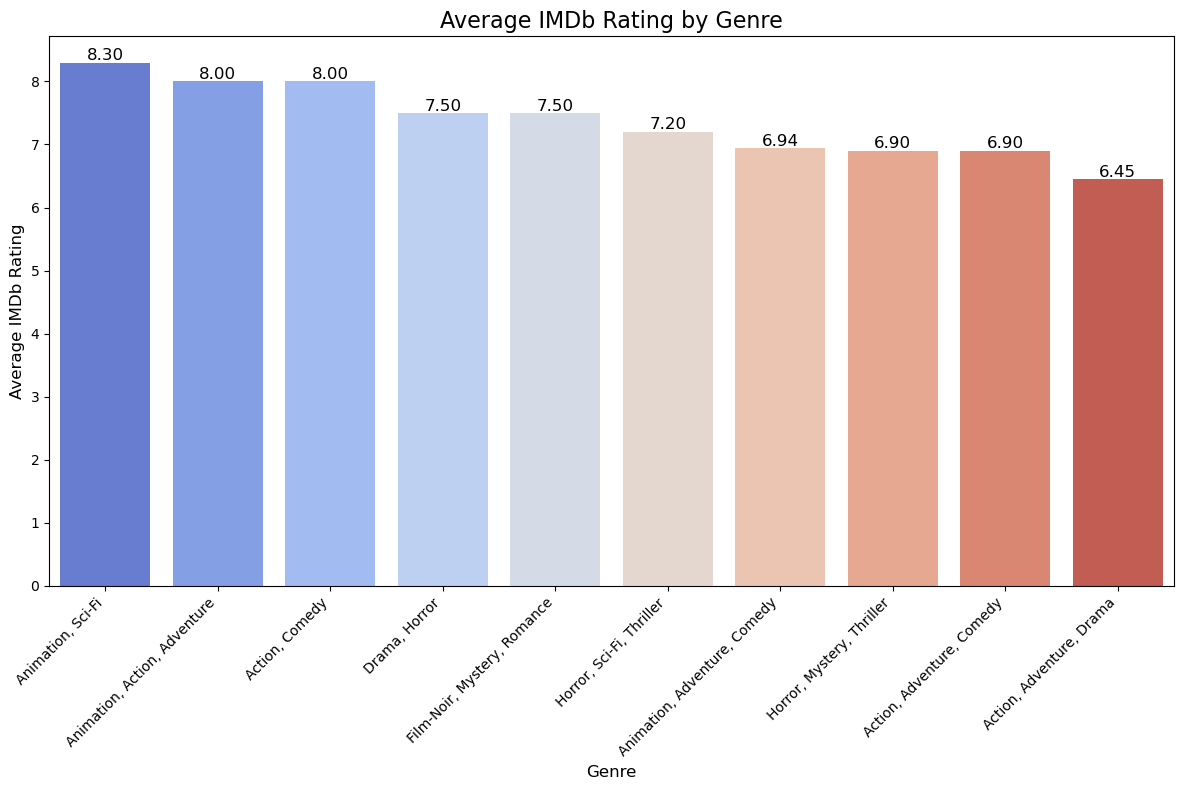

In [310]:
# 1. Popularity by Genre (Average IMDb Rating by Genre)
import matplotlib.pyplot as plt
import seaborn as sns

# Improve figure size
plt.figure(figsize=(12, 8))

# Calculate average IMDb rating by genre and sort
genre_popularity = df.groupby('Genre')['imdbRating'].mean().sort_values(ascending=False)

# Limit to top 10 genres for clarity
top_genres = genre_popularity.head(10)

# Plot with improved color palette and adjusted labels
ax = sns.barplot(x=top_genres.index, y=top_genres.values, palette='coolwarm')

# Rotate the genre labels for better readability
plt.xticks(rotation=45, ha='right')

# Set title and labels with improvements
plt.title('Average IMDb Rating by Genre', fontsize=16)
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Average IMDb Rating', fontsize=12)

# Display the values on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


C:\Users\handd\AppData\Local\Temp\ipykernel_16844\845480568.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=movies_per_year.index, y=movies_per_year.values, palette='viridis')


AttributeError: 'Text' object has no property 'xytext'

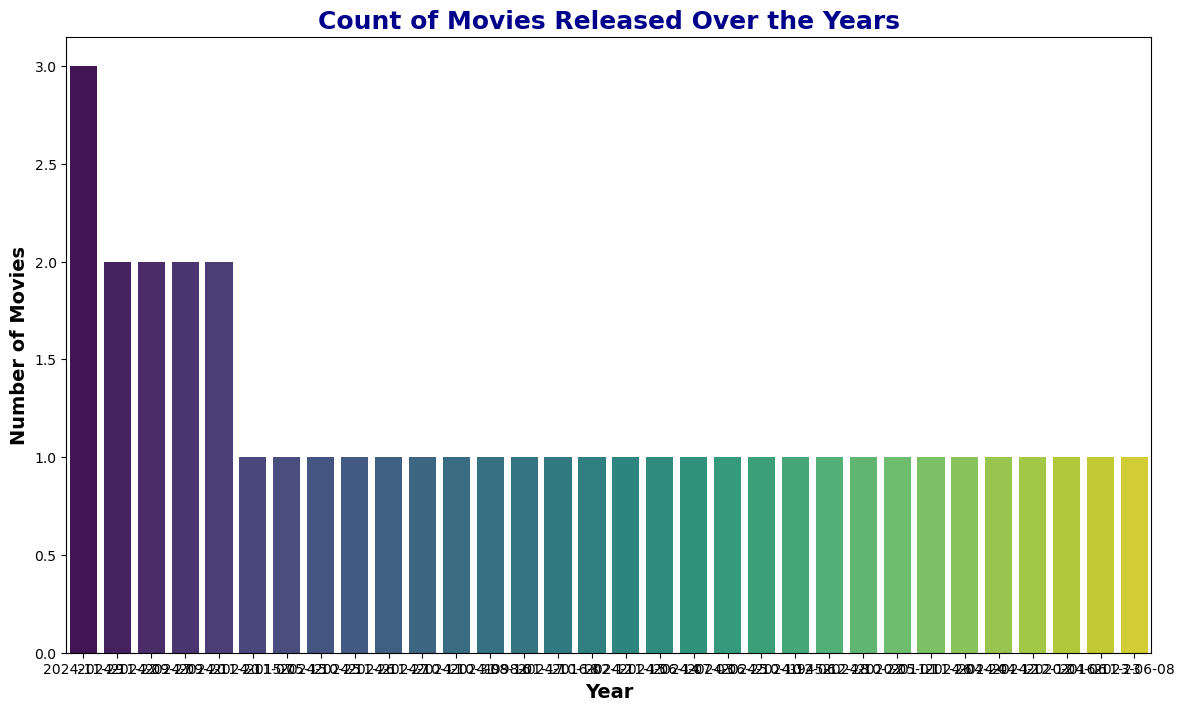

In [315]:
# 2. Count of Movies Over the Years
# Count of movies per year and sort by count (tallest to smallest)
movies_per_year = df['Released'].value_counts().sort_values(ascending=False)

# Plot the data
plt.figure(figsize=(14, 8))

# Choose a more sophisticated color palette
sns.barplot(x=movies_per_year.index, y=movies_per_year.values, palette='viridis')

# Title and labels with improved fonts and size
plt.title('Count of Movies Released Over the Years', fontsize=18, fontweight='bold', color='darkblue')
plt.xlabel('Year', fontsize=14, fontweight='bold', color='black')
plt.ylabel('Number of Movies', fontsize=14, fontweight='bold', color='black')

# Add annotations to each bar with better positioning and font size
for i, v in enumerate(movies_per_year.values):
    plt.text(i, v + 0.1, str(v), ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')

# Rotate x-axis labels for readability and format them to show only the year
plt.xticks(rotation=45, ha='right')

# Add gridlines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Improve layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


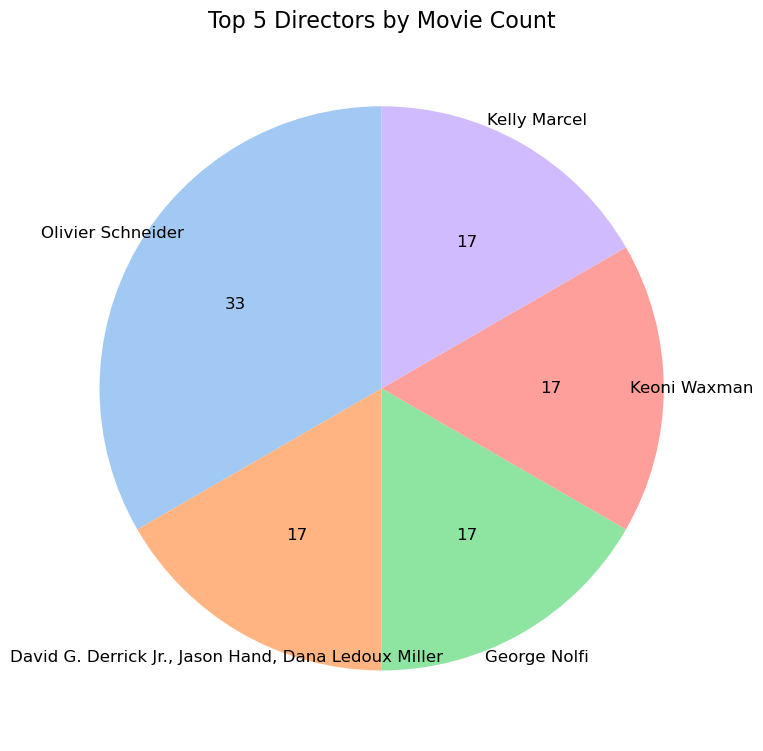

In [314]:
# 3. Top Directors by Movie Count
# Get the top 5 directors by movie count
top_directors = director_counts.head(5)

# Set up the color palette
colors = sns.color_palette("pastel", n_colors=5)

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(top_directors.values, labels=top_directors.index, autopct='%1.0f', colors=colors,
        startangle=90, textprops={'ha': 'center', 'va': 'center', 'fontsize': 12, 'color': 'black'})

# Title
plt.title('Top 5 Directors by Movie Count', fontsize=16)

# Display the plot
plt.tight_layout()
plt.show()


C:\Users\handd\AppData\Local\Temp\ipykernel_16844\297914023.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='imdbRating', y='Title', data=top_movies, palette='coolwarm')


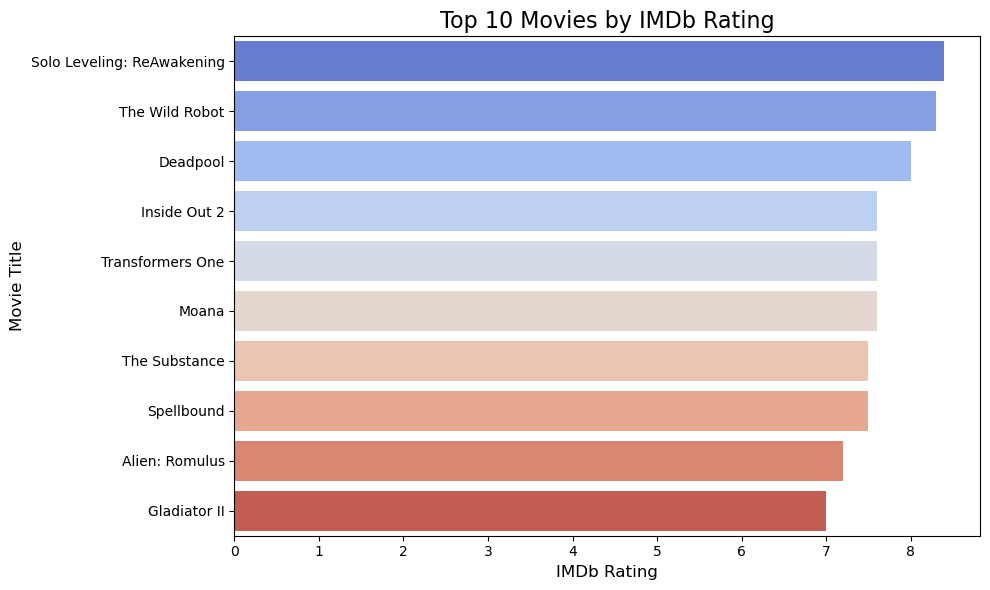

In [316]:
# 4. Top 10 Movies by IMDb Rating
# Sort the DataFrame by IMDb rating and get the top 10
top_movies = df.sort_values('imdbRating', ascending=False).head(10)

# Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='imdbRating', y='Title', data=top_movies, palette='coolwarm')

# Add titles and labels
plt.title('Top 10 Movies by IMDb Rating', fontsize=16)
plt.xlabel('IMDb Rating', fontsize=12)
plt.ylabel('Movie Title', fontsize=12)

# Display the plot
plt.tight_layout()
plt.show()
